In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
%cd Image denoising

/content/drive/MyDrive/Image denoising


In [ ]:
%cd MWCNN

/content/drive/MyDrive/Image denoising/MWCNN


In [ ]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import cv2
import skimage
from skimage.util import random_noise
import tensorflow as tf

from tqdm.notebook import tqdm
import random

In [ ]:
def get_images_paths(root_dir):
    # Getting dataset images
    root = pathlib.Path(root_dir)
    img_paths = list(root.rglob("*.png*"))
    img_paths_lst = [str(path) for path in img_paths]

    gt_lst = []
    noisy_lst= []
    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('.')[0]
        if img_type=='199':
          continue
        noisy_lst.append(p)
    for o in img_paths_lst:
        img_type = o.split("/")[-1].split('.')[0]
        gt_lst.append(o)
    # print(gt_lst)
    gt_lst1 = []
    for i in gt_lst:
      img_type = i.split("/")[-1].split('.')[0]
      if img_type=='199':
        gt_lst1.append(i)

    gt_lst1 = (len(gt_lst)-1)*gt_lst1

    noisy_array = np.asarray(noisy_lst)
    gt_array = np.asarray(gt_lst1)
    return noisy_array, gt_array

In [ ]:
noisy_train_paths, gt_train_paths = get_images_paths("exp1/images/train")
noisy_test_paths, gt_test_paths = get_images_paths("exp1/images/test")

In [ ]:
print(noisy_train_paths.shape)
print(noisy_test_paths.shape)
print(gt_train_paths.shape)
print(gt_test_paths.shape)

(50,)
(10,)
(50,)
(10,)


In [ ]:
# Get gt_images in memory
def get_images_in_mem(images_paths):
    images_lst = []
    for img_path in tqdm(images_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images_lst.append(img)
    return np.array(images_lst)

In [ ]:
noisy_train_images = get_images_in_mem(noisy_train_paths)
noisy_test_images = get_images_in_mem(noisy_test_paths)

gt_train_images = get_images_in_mem(gt_train_paths)
gt_test_images = get_images_in_mem(gt_test_paths)

print(noisy_train_images.shape)
print(noisy_test_images.shape)

print(gt_train_images.shape)
print(gt_test_images.shape)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(50, 128, 128, 3)
(10, 128, 128, 3)
(50, 128, 128, 3)
(10, 128, 128, 3)


In [ ]:
def tf_data_generator(X, y, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) # This is the main step for data generation
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)

    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

BATCH_SIZE=4

image_generator_train = tf_data_generator(X=noisy_train_images, y=gt_train_images, batch_size=BATCH_SIZE)
image_generator_test = tf_data_generator(X=noisy_test_images, y=gt_test_images, batch_size=BATCH_SIZE)

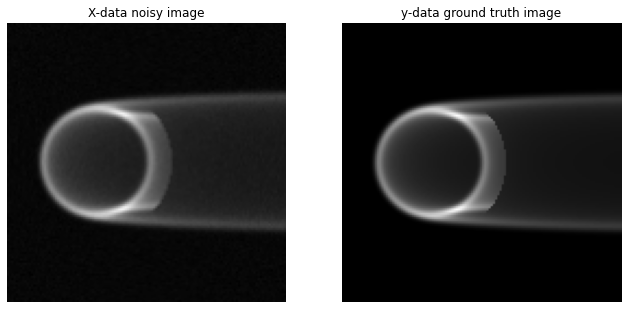

In [ ]:
# SANITY CHECK of the Dataset generator
for noisy, gt in image_generator_train.take(1):  # only take first element of dataset
    numpy_images = noisy.numpy()
    numpy_labels = gt.numpy()

f, axarr = plt.subplots(1,2, figsize=(11,11))
axarr[0].imshow(numpy_images[1])
axarr[0].set_title("X-data noisy image")
axarr[0].set_axis_off()

axarr[1].imshow(numpy_labels[1])
axarr[1].set_title("y-data ground truth image")
axarr[1].set_axis_off()

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,\
                                    GlobalAveragePooling2D, AveragePooling2D, MaxPool2D, UpSampling2D,\
                                    BatchNormalization, Activation,ELU, ReLU, Flatten, Dense, Input,\
                                    Add, Multiply, Concatenate, Softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import softmax

tf.keras.backend.set_image_data_format('channels_last')
import keras.backend as K

In [ ]:
class Conv_block(tf.keras.layers.Layer):
    def  __init__(self, num_filters=200, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.num_filters=num_filters
        self.kernel_size=kernel_size
        self.conv_1 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_2 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_3 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')
        self.conv_4 = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, padding='same')

        self.bn_1 = BatchNormalization()
        self.bn_2 = BatchNormalization()
        self.bn_3 = BatchNormalization()
        self.bn_4 = BatchNormalization()

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_filters': self.num_filters,
            'kernel_size':self.kernel_size
        })
        return config

    def call(self, X):
        X = self.conv_1(X)
        # X = self.bn_1(X)
        X = ELU()(X)
        X = self.conv_2(X)
        # X = self.bn_2(X)
        X = ELU()(X)
        X = self.conv_3(X)
        # X = self.bn_3(X)
        X = ELU()(X)
        # X = self.conv_4(X)
        # # X = self.bn_4(X)
        # X = ReLU()(X)

        return X

In [ ]:
class DWT_downsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        """
        The following calculations for DWT are inspired from,
        https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
        """
        x1 = x[:, 0::2, 0::2, :] #x(2i−1, 2j−1)
        x2 = x[:, 1::2, 0::2, :] #x(2i, 2j-1)
        x3 = x[:, 0::2, 1::2, :] #x(2i−1, 2j)
        x4 = x[:, 1::2, 1::2, :] #x(2i, 2j)

        x_LL = x1 + x2 + x3 + x4
        x_LH = -x1 - x3 + x2 + x4
        x_HL = -x1 + x3 - x2 + x4
        x_HH = x1 - x3 - x2 + x4

        return Concatenate(axis=-1)([x_LL, x_LH, x_HL, x_HH])

In [ ]:
class IWT_upsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, x):
        """
        The following calculations for IWT are inspired from,
        https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
        """
        x_LL = x[:, :, :, 0:x.shape[3]//4]
        x_LH = x[:, :, :, x.shape[3]//4:x.shape[3]//4*2]
        x_HL = x[:, :, :, x.shape[3]//4*2:x.shape[3]//4*3]
        x_HH = x[:, :, :, x.shape[3]//4*3:]

        x1 = (x_LL - x_LH - x_HL + x_HH)/4
        x2 = (x_LL - x_LH + x_HL - x_HH)/4
        x3 = (x_LL + x_LH - x_HL - x_HH)/4
        x4 = (x_LL + x_LH + x_HL + x_HH)/4

        y1 = K.stack([x1,x3], axis=2)
        y2 = K.stack([x2,x4], axis=2)
        shape = K.shape(x)
        return K.reshape(K.concatenate([y1,y2], axis=-1), K.stack([shape[0], shape[1]*2, shape[2]*2, shape[3]//4]))

In [ ]:
def create_model():
    tf.keras.backend.clear_session()

    input = Input(shape=(128,128,3))

    cb_1 = Conv_block(num_filters=64)(input)
    dwt_1 = DWT_downsampling()(cb_1)

    cb_2 = Conv_block(num_filters=128)(dwt_1)
    dwt_2 = DWT_downsampling()(cb_2)

    # cb_3 = Conv_block(num_filters=256)(dwt_2)
    # dwt_3 = DWT_downsampling()(cb_3)

    # cb_4 = Conv_block(num_filters=512)(dwt_3)
    # dwt_4 = DWT_downsampling()(cb_4)

    cb_5 = Conv_block(num_filters=512)(dwt_2)
    cb_5 = BatchNormalization()(cb_5)
    cb_5 = Conv_block(num_filters=512)(cb_5)
    cb_5 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(cb_5)

    # up = IWT_upsampling()(cb_5)
    # up = Conv_block(num_filters=512)(Add()([up, cb_4]))
    # up = Conv2D(filters=1024, kernel_size=3, strides=1, padding='same')(up)

    # up = IWT_upsampling()(cb_5)
    # up = Conv_block(num_filters=256)(Add()([up, cb_3]))
    # up = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(cb_5)
    up = Conv_block(num_filters=128)(Add()([up, cb_2]))
    up = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(up)

    up = IWT_upsampling()(up)
    up = Conv_block(num_filters=64)(Add()([up, cb_1]))
    up = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(up)

    out = Conv2D(filters=3, kernel_size=(1, 1), padding="same")(up)
    out = Flatten()(out)
    out = Dense(1000)(out)

    # out = Dense(1, activation='sigmoid')(out)

    return Model(inputs=[input], outputs=[out])

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_block (Conv_block)        (None, 128, 128, 64  75648       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dwt_downsampling (DWT_downsamp  (None, 64, 64, 256)  0          ['conv_block[0][0]']             
 ling)                                                                                        

In [ ]:
steps_per_epoch_train = len(noisy_train_images)
steps_per_epoch_validation = len(noisy_test_images)

In [ ]:
callbacks_lst = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.70, patience=3, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=10)
]

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.0009))
model.fit(image_generator_train,
          validation_data=image_generator_test,
                        steps_per_epoch=steps_per_epoch_train,
                        validation_steps=steps_per_epoch_validation,
                        epochs=100,
                        verbose=1,
                        callbacks=callbacks_lst)

Epoch 1/100
50/50 [==============================] - 16s 144ms/step - loss: 97.3335 - val_loss: 64.1929 - lr: 9.0000e-04
Epoch 2/100
50/50 [==============================] - 7s 133ms/step - loss: 64.1852 - val_loss: 64.1815 - lr: 9.0000e-04
Epoch 3/100
50/50 [==============================] - 7s 135ms/step - loss: 64.1808 - val_loss: 64.1807 - lr: 9.0000e-04
Epoch 4/100
50/50 [==============================] - 7s 137ms/step - loss: 64.1802 - val_loss: 64.1802 - lr: 9.0000e-04
Epoch 5/100
50/50 [==============================] - 7s 141ms/step - loss: 64.1799 - val_loss: 64.1799 - lr: 9.0000e-04
Epoch 6/100
50/50 [==============================] - 7s 140ms/step - loss: 64.1797 - val_loss: 64.1797 - lr: 9.0000e-04
Epoch 7/100
50/50 [==============================] - 7s 134ms/step - loss: 64.1795 - val_loss: 64.1796 - lr: 9.0000e-04
Epoch 8/100
50/50 [==============================] - 7s 137ms/step - loss: 64.1795 - val_loss: 64.1795 - lr: 9.0000e-04
Epoch 9/100
50/50 [====================

In [ ]:
best_models_path = "./"
model.save(best_models_path+"MWCNN_ablation_l_CC.h5")

In [ ]:
best_models_path = "./"
model = tf.keras.models.load_model(best_models_path+'MWCNN_ablation_l_CC.h5', custom_objects={'DWT_downsampling':DWT_downsampling,
                                                                                                        'IWT_upsampling':IWT_upsampling,
                                                                                                        'Conv_block':Conv_block})

In [ ]:
# Inference
def inference_single_image(model, noisy_image):
    input_image = np.expand_dims(noisy_image, axis=0)
    predicted_image = model.predict(input_image)

    return predicted_image[0]

def inference_batch_images(model, noisy_images):
    predicted_image = model.predict(noisy_images)
    return predicted_image

In [ ]:
def visualize_predictions(model, X_test, y_test, n):
    random_numbers = random.choices(range(X_test.shape[0]), k=n)    # Get n random indices
    for i in random_numbers:
        noisy_image = X_test[i]
        gt_image = y_test[i]
        predicted_image = inference_single_image(model, X_test[i])
        predicted_image/=255

        f, axarr = plt.subplots(1,3, figsize=(10,10))
        axarr[0].imshow(noisy_image)
        axarr[0].set_title("Noisy image")
        axarr[0].set_axis_off()
        axarr[1].imshow(gt_image)
        axarr[1].set_title("Ground truth image")
        axarr[1].set_axis_off()
        axarr[2].imshow(predicted_image)
        axarr[2].set_title("Predicted image")
        axarr[2].set_axis_off()



In [ ]:
from skimage.metrics import peak_signal_noise_ratio

predicted_images = inference_batch_images(model, noisy_test_images)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=gt_test_images.shape[0]
psnr_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

1/1 [==============================] - 1s 1s/step
Original average gt-noisy PSNR -> 30.25217085992565
Predicted average gt-predicted PSNR -> -23.42514451666461


In [ ]:
from skimage.metrics import structural_similarity as ssim

predicted_images = inference_batch_images(model, noisy_test_images)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(gt_test_images, noisy_test_images, predicted_images):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=gt_test_images.shape[0]
ssim_prediction_mean/=gt_test_images.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

1/1 [==============================] - 0s 17ms/step
Original average gt-noisy SSIM -> 0.5450734549641099
Predicted average gt-predicted SSIM -> 0.006487816672051646
